In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/강의 자료들/2025/250701 인사교 6기 자연어처리 B반/딥러닝 기초 25.07.11 (class 2)

/content/drive/.shortcut-targets-by-id/1BetU2RLJA7gC3DgSstzRg0db8buEhQBE/딥러닝 기초 25.07.11 (class 2)


In [3]:
!pip -q install transformers[torch] datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.7 MB/s eta 0:00:00


- 파인튜닝 없이, 모델들 활용해서 요약-임베딩-클러스터링-감성분석을 포함하는 통합적 분석 파이프라인을 구축

## 시나리오

### 배경
- “K-인사이트”는 <u>월간 **50만 건** 이상의 SNS 대화를 처리하는 기업용 분석 플랫폼</u>  
- AI Hub의 한국어 SNS 데이터(“미용과건강”, “식음료”, “일과직업”) 기반으로 사용자의 대화 내용을 <u>자동 탐지·분류</u>해야 함  
- 긴 대화 로그에는 <u>메타정보·반복 발화·잡음</u>이 포함되어 있어, <u>핵심 주제 파악</u>과 <u>감성 분석</u>이 어려움  
- <u>요약 → 임베딩 → 클러스터링 → 감성분석</u>의 통합 파이프라인으로 <u>자동 인사이트 생성</u>이 필요  

```python
# 주요 이해관계자
- 데이터 사이언스팀 : 통합 분석 파이프라인 개발·유지보수  
- 제품 기획팀       : 사용자 인사이트 기반 서비스 기획  
- 운영팀           : 실시간 토픽·감성 모니터링 시스템 운영  
- 마케팅팀         : 토픽별 감성 결과로 캠페인 전략 수립  
```

In [4]:
# !unzip -q ./data/Korean\ SNS.zip -d ./data/Korean_SNS

In [5]:
import os, json, re

In [6]:
train_dir = "./data/Korean_SNS/Training/"
val_dir = "./data/Korean_SNS/Validation/"

# train set - 약 35만개 가량, val set - 약 4만개 가량
# 각 라벨별로 200개씩만 활용
limit_per_label = 200

In [7]:
# JSON(보통 API로 데이터를 주고 받을 때 사용하는 JavaScript 객체 파일) 파일 로드

# 샘플 선택
sample_fname = os.listdir(train_dir)[0]
sample_path = os.path.join(train_dir, sample_fname)
sample_path

'./data/Korean_SNS/Training/미용과건강.json'

In [8]:
# JSON 파일 로드
with open(sample_path, "r", encoding = "utf-8") as f :
    dataset = json.load(f)

In [9]:
dataset.keys()

dict_keys(['numberOfItems', 'data'])

In [10]:
# 첫번째 대화 선택
sample_dialog = dataset["data"][0]

In [11]:
sample_dialog["body"][4]["utterance"] # 발화

'님 괜찮아여?'

In [12]:
# 하나의 문서로 만들기
semple_text = " ".join(turn["utterance"] for turn in sample_dialog["body"])

In [13]:
semple_text

'마니아프세여??? #@시스템#사진# 흙흙흙 아 개피곤 ㅋㅋ 님 괜찮아여? 왜 먹고 먹고 머고만 햇는데 몸이 무겁지 걸은것도 별로 없는데 몰라여 응가싸서 그런가 고되다 똥싸서 몸무게 빠졋나 아삐건해 미틴ㅋㅋㅋㅋㅋㅋ 진짜 7-800그람 빠짐 나 몸이 너무 무거워서 몸무게 쟀는데 빠져서 놀랏어 너무 무서워'

In [14]:
from tqdm.auto import tqdm

In [15]:
# dir_path 내에 있는 모든 JSON 순회해서
# 각 대화(dialog)에 body 필드에 접근
# utternace(발화)들을 하나의 문서(text)로 연결한 뒤
# 리스트로 반환하는 함수
def load_and_normalize(dir_path) :
    corpus = []

    # 해당 폴더 내 모든 파일 이름 가져와서 반복
    for fname in tqdm(os.listdir(dir_path), desc = f"Lading {dir_path}") :
        file_path = os.path.join(dir_path, fname)

        # JSON을 딕셔너리로 읽어오기
        with open(file_path, "r", encoding = "utf-8") as f:
            dataset = json.load(f)

        count = 0 # 반복 횟수 제한용
        # dataset의 data 안에 각 대화들을 순회
        for dialog in tqdm(dataset["data"], desc = f"processing {fname}") :

            if count >= limit_per_label :
                break

            text = " ".join( turn["utterance"] for turn in dialog["body"] )

            corpus.append(text)
            count += 1
    return corpus

In [16]:
train_corpus = load_and_normalize(train_dir)
val_corpus = load_and_normalize(val_dir)

Lading ./data/Korean_SNS/Training/:   0%|          | 0/3 [00:00<?, ?it/s]

processing 미용과건강.json:   0%|          | 0/99383 [00:00<?, ?it/s]

processing 일과직업.json:   0%|          | 0/107976 [00:00<?, ?it/s]

processing 식음료.json:   0%|          | 0/146620 [00:00<?, ?it/s]

Lading ./data/Korean_SNS/Validation/:   0%|          | 0/3 [00:00<?, ?it/s]

processing 일과직업.json:   0%|          | 0/13498 [00:00<?, ?it/s]

processing 미용과건강.json:   0%|          | 0/12423 [00:00<?, ?it/s]

processing 식음료.json:   0%|          | 0/18328 [00:00<?, ?it/s]

In [17]:
len(train_corpus), len(val_corpus)

(600, 600)

### 1. 대화 요약 (Summarization)
- 노이즈 제거 : 불필요한 대화, 중복 발화 등에 내용들을 걸러내는 역할
- 문서 길이 절감 : 연산속도 높임

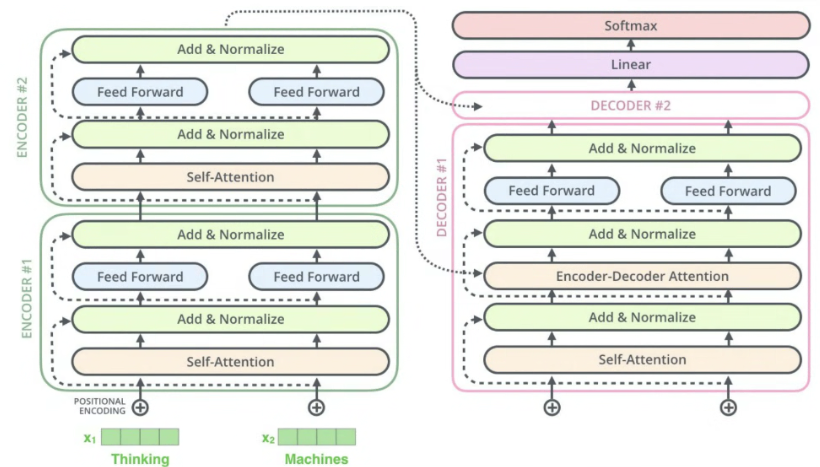

In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [19]:
model_name = "psyche/KoT5-summarization"

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [22]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

- 샘플 텍스트(문서)로 테스트

In [23]:
sample_text = train_corpus[0]

In [24]:
inputs = tokenizer(sample_text, return_tensors = "pt", truncation = True, max_length = 512).to(device)

In [25]:
outputs = model.generate(
    **inputs,
    max_length = 100,
    min_length = 20,
    num_beams = 4,   # 빔서치수(다음 출력 시퀀스 예측할 때 가능성이 높은 후보군을 4개 선정)
    early_stopping = True, # 출력 시퀀스에 대한 조기 종료 (EOS 토큰 만나는 즉시 종료)
    length_penalty = 2.0 # 출력 시퀀스 길이에다가 가중치를 조정
)                        # 1.0 < 값 : 출력 시퀀스가 길어질수록 페널티가 강해져서 짧은 시퀀스를 유도
                         # 1.0 > 값 : 출력 시퀀스에 대한 페널티 자체가 작아져서, 긴 시퀀스를 유도

In [26]:
# 정수 시퀀스 → 텍스트로 디코딩
tokenizer.decode(outputs[0], skip_special_tokens = True)

'왜 먹고 먹고만 햇는데 몸이 무겁지 걸은것도 별로 없는데 몰라여 응가싸서 그런가 고되다 똥싸서 몸무게 빠졋나 아삐건해 미틴 진짜 7-800그람 빠짐 나 몸이 너무 무거워서 몸무게 쟀는데 빠져서 놀란다'

In [27]:
# 텍스트 요약 함수 정의
def summarize(text) :
    # 1) 입력 토큰화 수행, 본인 디바이스로 이동
    inputs = tokenizer(text, return_tensors = "pt", truncation = True, max_length = 512).to(device)

    # 2) 출력시퀀스 생성
    outputs = model.generate(
        **inputs,
        max_length = 100,
        min_length = 20,
        num_beams = 4,
        early_stopping = True,
        length_penalty = 2.0
    )

    # 3) 디코딩으로 요약문 생성
    summary = tokenizer.decode(outputs[0], skip_special_tokens = True)
    return summary

In [29]:
# 함수 테스트
summarize(train_corpus[0])

'왜 먹고 먹고만 햇는데 몸이 무겁지 걸은것도 별로 없는데 몰라여 응가싸서 그런가 고되다 똥싸서 몸무게 빠졋나 아삐건해 미틴 진짜 7-800그람 빠짐 나 몸이 너무 무거워서 몸무게 쟀는데 빠져서 놀란다'

In [30]:
# 실습 상 Test set까지 하기에는 시간이 많이걸림...

# train set만 우선적으로 적용
summaries = [ summarize(doc) for doc in tqdm(train_corpus, desc = "summarizing") ]

summarizing:   0%|          | 0/600 [00:00<?, ?it/s]

### 2. 임베딩
- 텍스트를 수치화(벡터화, 밀집표현)로 변환하는 작업

- 인코딩 → BOW, TFIDF → 단어임베딩(Word2Vec) → 문서임베딩(Doc2Vec) → BERT 계열(트랜스포머 계열)

- Sentence BERT : BERT 모델을 문장 임베딩을 생성하는 모델로 활용할 수 있도록 설계 된 모델
    - 문장(Sentence) 간의 의미적 관계를 잘 보존하는 임베딩을 제공
    - 추천 알고리즘, 클러스터링, 시각화 등 다양한 분석 기법을 적용할 수 있는 이점이 존재

In [32]:
from sentence_transformers import SentenceTransformer # SBERT 임베딩 모델 로드용

# !pip -q install sentence-transformers

In [33]:
embedding_model = SentenceTransformer("snunlp/KR-SBERT-V40K-klueNLI-augSTS")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### 3. 토픽모델링 (BERTopic)
- Corpus 내에서 숨겨져있는 주제(토픽)을 찾아내는 텍스트마이닝 기법 중 하나 (정통통계학, LDA, BERTopic 등)
- 기계학습, 자연어 처리 분야에서 널리 사용 -> 문서들을 분석해서 어떤 주제들이 포함되어 있는지를 & 각 문서들이 어떤 주제와 연관되어 있는지를 파악하기 위한 도구

> BERTopic
> - Transformer 기반의 토픽 모델링 도구

> LDA(Latent Dirichlet Allocation)와의 차이점
> - LDA : 빈도수 기반으로 확률적 토픽 모델링 기법

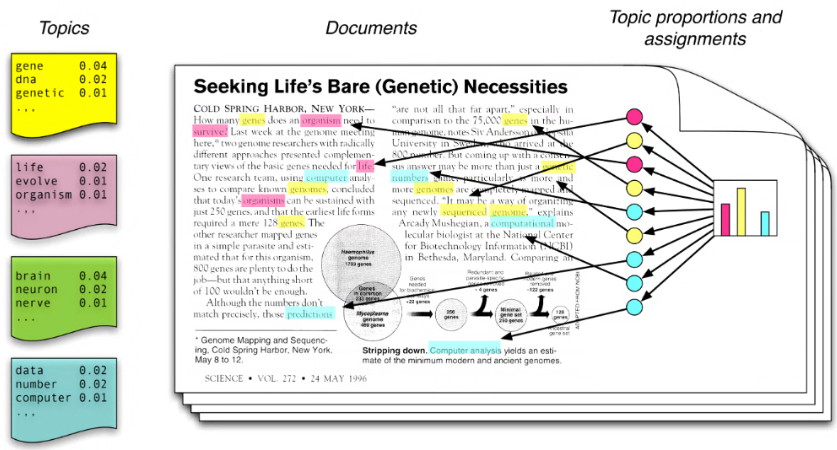

- BERTopic의 구성요소

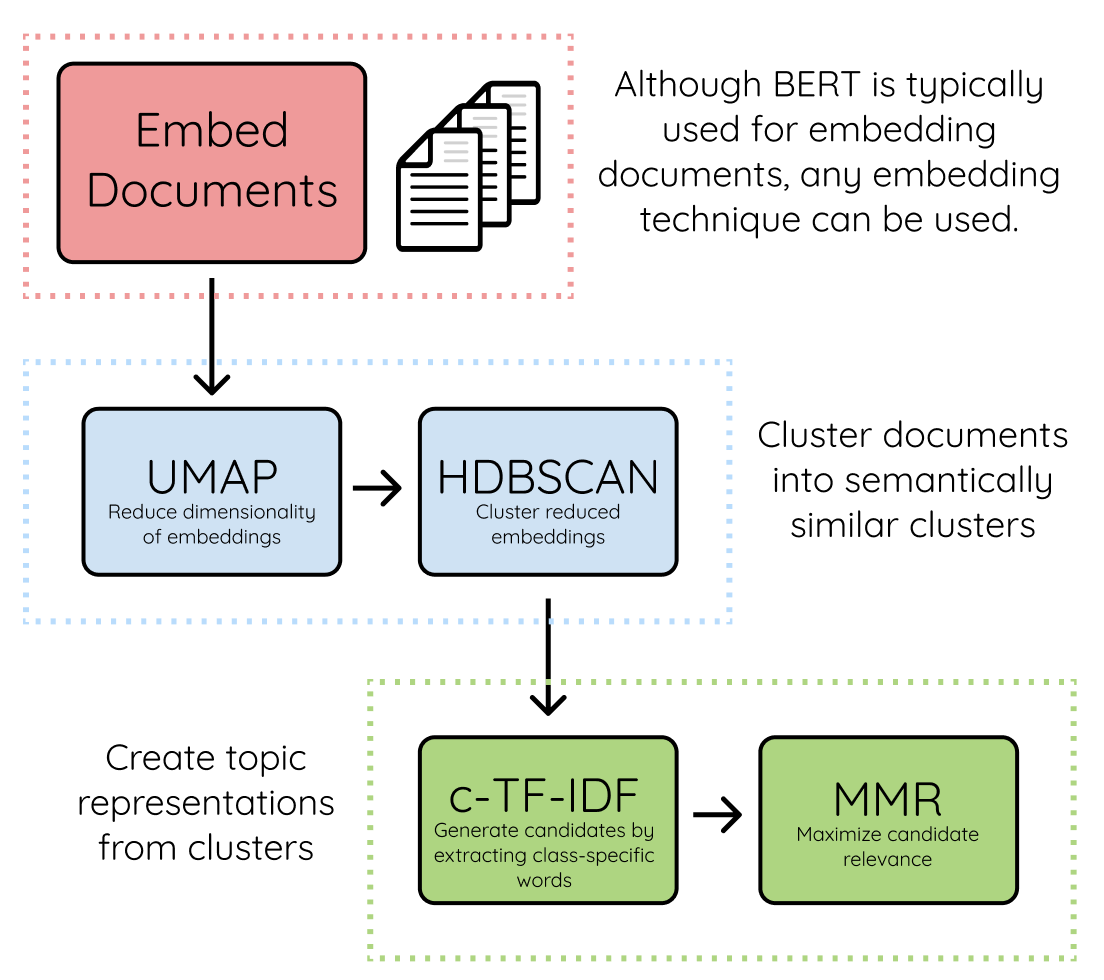

> BERTopic 장점
> - 의미 기반으로 토픽 추출 : 단순 단어 빈도만 보는 LDA 대비 더 정교
> - BERTopic은 알아서 토픽수를 결정

> BERTopic 단점
> - UMAP, HDBCAN의 파라미터 민감 (적절한 값으로 튜닝 필요)
> - 대규모 데이터셋에 시간이 많이 걸림

In [34]:
!pip -q install --upgrade bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.1 MB/s eta 0:00:00


In [35]:
from bertopic import BERTopic

In [37]:
# 버토픽 초기화
topic_model_orig = BERTopic(
    embedding_model = embedding_model,
    calculate_probabilities = True, # 문서별 토픽 확률값 반환
    verbose = True                  # 토피모델링 수행 시 출력 여부
)

In [38]:
# 원문에 대해 토픽 모델링 수행
topics_orig, probs_orig = topic_model_orig.fit_transform(train_corpus)

2025-08-04 02:15:41,700 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
2025-08-04 02:15:42,612 - BERTopic - Embedding - Completed ✓
2025-08-04 02:15:42,612 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-04 02:15:50,835 - BERTopic - Dimensionality - Completed ✓
2025-08-04 02:15:50,836 - BERTopic - Cluster - Start clustering the reduced embeddings
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-08-04 02:15:50,872 - BERTopic - Cluster - Complet

In [41]:
print(topics_orig) # 문서별 할당 된 토픽 번호 (-1은 Noise)
print(probs_orig)  # 문서가 해당 토픽에 속할 확률값

[0, 0, 1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, -1, -1, -1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, -1, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, -1, 0, 0, 1, 0, -1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 1, 0, 1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, -

In [43]:
topic_model_orig.get_topic_info() # 토픽 정보 확인

,Topic,Count,Name,Representation,Representative_Docs
0,-1,52,-1_진짜_오늘_이름_ㅎㅎ,"[진짜, 오늘, 이름, ㅎㅎ, ㅋㅋㅋ, ㅋㅋ, 근데, 이모티콘, 시스템, 너무]",[오늘의 스케줄은 어떻게 되~? 아 맞다 나는 #@이름#랑 3부 가려고 준비중 유치...
1,0,334,0_근데_이름_진짜_ㅠㅠ,"[근데, 이름, 진짜, ㅠㅠ, ㅋㅋㅋ, ㅋㅋ, 그냥, 그럼, 이모티콘, 너무]",[그 전달사항 2개있어요. 1. 어제 #@이름#님이 언제 결과 나오냐고 물어보셔서 ...
2,1,214,1_이름_시스템_사진_이모티콘,"[이름, 시스템, 사진, 이모티콘, ㅋㅋ, ㅋㅋㅋ, 오늘, ㅋㅋㅋㅋ, 그냥, 내가]",[엽떡에 닭볶음탕 맛있다던데 오 진짜 ㅋㅋㅋ 그것도 엄청 매우려나 어어 ㅋㅋ 엽떡이...


In [45]:
# 요약문에 대해서도 별도로 토픽모델링을 수행
topic_model_sum = BERTopic(embedding_model = embedding_model, calculate_probabilities = True, verbose = True)

topics_sum, probs_sum = topic_model_sum.fit_transform(summaries)

2025-08-04 02:24:34,792 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
2025-08-04 02:24:35,305 - BERTopic - Embedding - Completed ✓
2025-08-04 02:24:35,305 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-04 02:24:36,243 - BERTopic - Dimensionality - Completed ✓
2025-08-04 02:24:36,244 - BERTopic - Cluster - Start clustering the reduced embeddings
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-08-04 02:24:36,279 - BERTopic - Cluster - Complet

In [48]:
display(topic_model_orig.get_topic_info())
display(topic_model_sum.get_topic_info())

# 원문 vs 요약 : 원문에는 토픽 정의에 있어서 불필요한 토큰들이 많이 들어가 있음
# 요약이 그나마 쪼금 더 정제되어 있음

# 분석에 대한 성능을 올리고 싶다!
#  → 토픽모델링 이전에 적절한 전처리(형태소 선택, 불용어 제거 등) 등을
#  → 같이 수행하면 훨씬 더 명확한 토픽을 정의할 수 있음!

# 활용방안
#    → 주요 타겟층 명확화를 위해 페르소나 기법으로써 활용
#    → 고객 데이터(리뷰)인 경우, Needs나 Painpoint 기반으로 기능 제안에 활용 가능

,Topic,Count,Name,Representation,Representative_Docs
0,-1,52,-1_진짜_오늘_이름_ㅎㅎ,"[진짜, 오늘, 이름, ㅎㅎ, ㅋㅋㅋ, ㅋㅋ, 근데, 이모티콘, 시스템, 너무]",[오늘의 스케줄은 어떻게 되~? 아 맞다 나는 #@이름#랑 3부 가려고 준비중 유치...
1,0,334,0_근데_이름_진짜_ㅠㅠ,"[근데, 이름, 진짜, ㅠㅠ, ㅋㅋㅋ, ㅋㅋ, 그냥, 그럼, 이모티콘, 너무]",[그 전달사항 2개있어요. 1. 어제 #@이름#님이 언제 결과 나오냐고 물어보셔서 ...
2,1,214,1_이름_시스템_사진_이모티콘,"[이름, 시스템, 사진, 이모티콘, ㅋㅋ, ㅋㅋㅋ, 오늘, ㅋㅋㅋㅋ, 그냥, 내가]",[엽떡에 닭볶음탕 맛있다던데 오 진짜 ㅋㅋㅋ 그것도 엄청 매우려나 어어 ㅋㅋ 엽떡이...


,Topic,Count,Name,Representation,Representative_Docs
0,-1,18,-1_그치_엔터식스_웅웅_만들어서,"[그치, 엔터식스, 웅웅, 만들어서, 가고픈거, 샤브좋당, 사와, 말해쥬, 아니당,...",[자기 나즁에 나 출근시간 늦으면 김에 밥이라도 싸서 입에 넣어죠 옹옹 별모양으로 ...
1,0,367,0_맞아_근데_진짜_너무,"[맞아, 근데, 진짜, 너무, 오늘, 이름, 지금, 그냥, 내가, 나도]",[엄마한테 가격 말햇다가 근데 진짜 개에바다 330이면 #@이름#이 눈하고 코까지 ...
2,1,215,1_먹고_오늘_그냥_후후,"[먹고, 오늘, 그냥, 후후, 근데, 나는, 이름, 먹을, 내가, 너무]",[소주먹을일이 엄씀 근데 팥빙스는 물많아 저거 내개좋아하거근 후후 후후 개마시쌍 후...


In [52]:
# 대표 키워드들 살펴보기
info_sum = topic_model_sum.get_topic_info()

info_sum["Representation"][1] # 0번 토픽의 주요 키워드

['맞아', '근데', '진짜', '너무', '오늘', '이름', '지금', '그냥', '내가', '나도']

In [59]:
# 0번 토픽별 상위 키워드 리스트
topic_model_sum.get_topic(0) # 높을수록 해당 토픽을 잘 대표하는 키워드

[('맞아', np.float64(0.04438433091627938)),
 ('근데', np.float64(0.032239024129981225)),
 ('진짜', np.float64(0.02455528416079911)),
 ('너무', np.float64(0.02312262509504035)),
 ('오늘', np.float64(0.020703013547815723)),
 ('이름', np.float64(0.019643670497429024)),
 ('지금', np.float64(0.018681820555848182)),
 ('그냥', np.float64(0.01791423566241499)),
 ('내가', np.float64(0.015924910050036493)),
 ('나도', np.float64(0.014826020422835795))]

In [64]:
# 토픽 번호별로 키워드
for t in info_sum["Topic"].unique() :
    if t == -1 :
        continue

    print(f"토픽 {t} 키워드 :")
    display(topic_model_sum.get_topic(t))

토픽 0 키워드 :


[('맞아', np.float64(0.04438433091627938)),
 ('근데', np.float64(0.032239024129981225)),
 ('진짜', np.float64(0.02455528416079911)),
 ('너무', np.float64(0.02312262509504035)),
 ('오늘', np.float64(0.020703013547815723)),
 ('이름', np.float64(0.019643670497429024)),
 ('지금', np.float64(0.018681820555848182)),
 ('그냥', np.float64(0.01791423566241499)),
 ('내가', np.float64(0.015924910050036493)),
 ('나도', np.float64(0.014826020422835795))]

토픽 1 키워드 :


[('먹고', np.float64(0.030841210342304224)),
 ('오늘', np.float64(0.029053696396167998)),
 ('그냥', np.float64(0.026364401481830346)),
 ('후후', np.float64(0.024866232088173564)),
 ('근데', np.float64(0.024533589321129128)),
 ('나는', np.float64(0.02446463448043688)),
 ('이름', np.float64(0.023363286358635226)),
 ('먹을', np.float64(0.018845987557568326)),
 ('내가', np.float64(0.018708249896804672)),
 ('너무', np.float64(0.017619875271279218))]

### 4. 결과 비교, 시각화

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn의 경우, font_manager 로 직접 추가해야 한글 시각화 가능
import matplotlib.font_manager as fm

# 폰트 경로 추가
font_path = "./data/GULIM.TTC"
fm.fontManager.addfont(font_path)

In [68]:
font_prop = fm.FontProperties(fname = font_path)
font_name = font_prop.get_name()

plt.rcParams["font.family"] = font_name
plt.rcParams["axes.unicode_minus"] = False

- 4.1 토픽에 대한 분포 비교

In [71]:
# 토픽 비교용 DF 생성
df_topic_compare = pd.DataFrame({"original" : topics_orig, "summary" : topics_sum})

In [76]:
orig_topic_counts = df_topic_compare["original"].value_counts().sort_index()
summary_topic_counts = df_topic_compare["summary"].value_counts().sort_index()

In [82]:
# 하나의 DF로 합치기
df_topic_counts = pd.concat([orig_topic_counts, summary_topic_counts], axis = 1, keys = ["orig_count", "sum_count"])

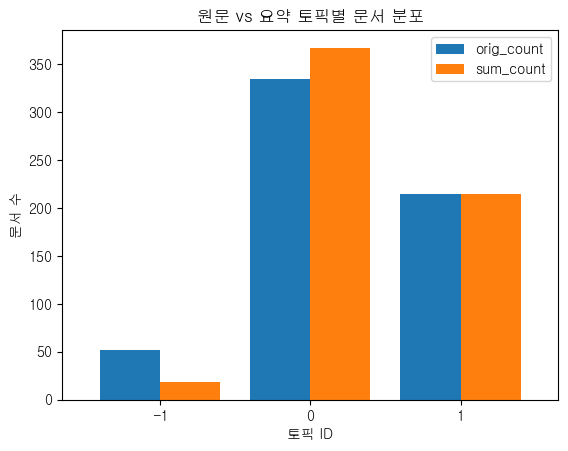

In [94]:
# 막대 차트
df_topic_counts.plot(kind = "bar", width = 0.8)

plt.title("원문 vs 요약 토픽별 문서 분포")
plt.xlabel("토픽 ID")
plt.ylabel("문서 수")
plt.xticks(rotation = 0)
plt.show()

# 토픽 모델링의 여러 사례들(페르소나 정의, Action 등)에 대한 결과를 도출하기 위해서는
# 여러 실험결과들이 필요함! → A : 원문, B : 요약, C : 요약 + 전처리....

- 4.2 토픽별로 대표 키워드 & 문장 파악

In [102]:
# 원문과 요약에서 사용된 최대 토픽 ID 개수를 계산
max_topic = max(df_topic_compare["original"].max(), df_topic_compare["summary"].max())
max_topic

1

In [113]:
# 0부터 max_topic까지 반복하면서, 각 토픽을 비교
for t in range(0, max_topic + 1) :
    if t not in topic_model_orig.get_topic_info()["Topic"].values or t not in topic_model_sum.get_topic_info()["Topic"].values :
        continue
    print(f"\n ==== 토픽 {t} ==== ")
    print("원문 키워드 : ", [ w for w, _ in topic_model_orig.get_topic(t)][:5])
    print("요약 키워드 : ", [ w for w, _ in topic_model_sum.get_topic(t)][:5])
    print("원문 대표문장 : ", topic_model_orig.get_representative_docs(t)[:5])
    print("요약 대표문장 : ", topic_model_sum.get_representative_docs(t)[:5])

# 원문
# 토픽 0 : 등록이나 회원 관련된 주제
# 토픽 1 : 음식과 관련 된 주제

# 요약문
# 토픽 0 : 결제와 관련 된 주제
# 토픽 1 : 음식과 관련 된 주제


 ==== 토픽 0 ==== 
원문 키워드 :  ['근데', '이름', '진짜', 'ㅠㅠ', 'ㅋㅋㅋ']
요약 키워드 :  ['맞아', '근데', '진짜', '너무', '오늘']
원문 대표문장 :  ['그 전달사항 2개있어요. 1. 어제 #@이름#님이 언제 결과 나오냐고 물어보셔서 지금 학습하는거 하고있다구 했구, 2. #@이름#님이 우리 인력하는거 코사에 등록할수있을거라고 나중에 이거 끝나면 코사에 등록하라고 하시네여 1. 학습하는거 언제까지 한다고 말씀드리거나, 언제까지 하라고 말씀해주신게 있나요 ? 빨리해라 라는 뉘앙스라도. 2. 이거 끝나면이라는건 #@이름#님께서 결과 이정도면 ok라고 하실때를 말씀하시는거겠죠 ? 1. 빨리해라 뉘양스였구요 2. 모르겠어요 넹 감사합니당 #@이름#씨 저 점심에 약속 잡혔는데 식사 나가서 먹고 와도 될까용 ?.. 그래요 근데 그냥 말만해주면되는데 왜 내 의사를 물어봐요? 너희 약속이고 허락받는거같아서 뭔가 내가 기분이 이상해 ㅋㅋ 혹시 심기가 불편하신가여 ?.. 아니 그냥 뭔가.. 왜?" 아니 그냥 ..', '근데 내가 강남병원 갔잖아 근데 수포가 올라오면 주는게 맞긴 한데 그 할아버지 의사도 스프레이 처방해달라고 하나 하니깐, 금방 나을껀대 비싸게 그건 왜 하냐고 #@이름# 심하지 않아 그런거 아냐 난 #@이름# 전날 밤새 한숨도 안자고 오열해서 그 아침에 스프레이 뿌리면 그래도 물 마시고 다시 자고 그러더라고 근데 #@이름# 지금까지 구내염 3번인대 스프레이는 너한테 처음 들었어 스프레이가 탄툼이자나 그 헥사메딘이랑 비슷한거거든 그동안 갔던 모든 병원 안줬어 어른은 가글을 할수있는데 애들은 가글 안하니까 그게 필수는 아냐 #@이름#  스프레이 싫어해서 뿌리지도 못함 ㅋ 그냥 통증을 잠시 완화 시키는거지 뭐 암튼 난 그냥 꿈이든 돌고래 다닐래... 난 그냥 기침약 잘 받아서 거기간다 ㅋㅋㅋㅋㅋㅋㅋㅋ 그래 ㅋㅋㅋㅋ', '근데 가끔 담배때문에 머리 아플때가 있음 ㅋㅋㅋ 그럼 피면 안되지 그러니까 ㅋㅋ 근데 안 필수가 없지

- 4.3 토픽별 확률 히트맵

In [116]:
# 토픽 확률 배열
df_probs_orig = pd.DataFrame(probs_orig, columns = topic_model_orig.get_topic_info()["Topic"][1:])
df_probs_sum = pd.DataFrame(probs_sum, columns = topic_model_sum.get_topic_info()["Topic"][1:])

In [129]:
# 양쪽 모델에 공통으로 존재하는 토픽 ID값만 추출
common_topics = sorted(set(df_probs_orig.columns) & set(df_probs_sum.columns))

In [130]:
common_topics # 공통 토픽

[0, 1]

In [135]:
# 공통 토픽별로 확률값을 계산
orig_mean = df_probs_orig[common_topics].mean().rename("original")
sum_mean = df_probs_sum[common_topics].mean().rename("summary")

In [138]:
df_prob_cat = pd.concat([orig_mean, sum_mean], axis = 1)
df_prob_cat

,original,summary
Topic,,
0,0.555196,0.555019
1,0.378132,0.397886


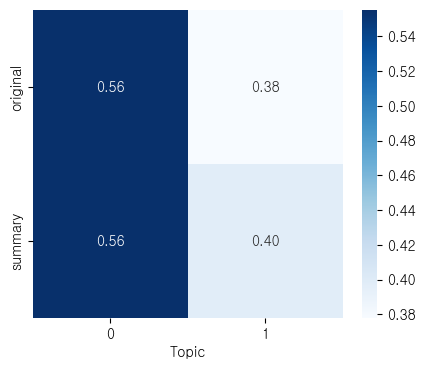

In [139]:
# 히트맵
plt.figure(figsize = (5, 4))

sns.heatmap(df_prob_cat.T, annot = True, fmt = ".2f", cmap = "Blues")
plt.show()

In [141]:
# 토픽별 상위 키워드 바차트

topic_model_orig.visualize_barchart().show()
topic_model_sum.visualize_barchart().show()

### 결과 해석
- 600개의 데이터셋으로 여러 원인이 발생했을 수 있음
- 토픽모델링의 경우, 문서에서 말하고자 하는 주요 토픽(주제)를 간파하기 위한 도구
    - 여러 시각화나 EDA를 통해 클러스터링 된 토픽 ID를 기준으로 문서들을 살펴보고 토픽에 대해 정의하는게 중요!

### 5. 토픽별 감성분석
- 서비스 관점에서 `어떤 주제에 부정적인 반응이 많은가?`, `어떤 주제에 긍정적인지?` 등을 시각화해서 토픽 x 감성 간의 관계를 분석해볼 수도 있음

In [142]:
from transformers import pipeline

In [143]:
sentiment_analyzer = pipeline(
    task = "sentiment-analysis",
    model = "daekeun-ml/koelectra-small-v3-nsmc",
    tokenizer = "daekeun-ml/koelectra-small-v3-nsmc",
    device = 0
)

config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/56.5M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [147]:
# 각각의 텍스트(문서)들에 대해 감성 예측

sentiments = [] # 예측결과 담아두기

for doc in tqdm(train_corpus) :
    # BERT, T5 계열의 모델들은 position embedding 길이는 보통은 512차원을 사용
    result = sentiment_analyzer(doc[:512])[0]

    sent_label = "negative" if result["label"] == "0" else "positive"
    sentiments.append(sent_label)

  0%|          | 0/600 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning:

`encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `ElectraSelfAttention.forward`.

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [152]:
df_topic_sent = pd.DataFrame({"topic" : topics_sum , "sentiment": sentiments})

In [156]:
ct = pd.crosstab(df_topic_sent["topic"], df_topic_sent["sentiment"])

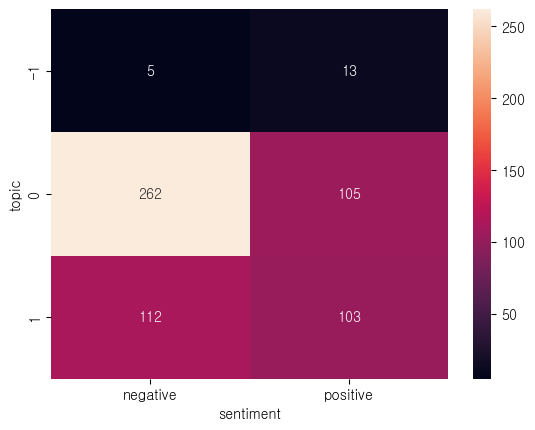

In [157]:
sns.heatmap(ct, annot = True, fmt = "d")

plt.show()